In [122]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import cvxpy as cp


In [13]:
def save_stats(array, file_name):
    stats_file = open(file_name, "w")
    np.savetxt(stats_file, array)
    stats_file.close()

def read_stats(file_name):
    df = pd.read_csv(file_name, header= None, names=['score'])
    return df

In [14]:
class SoccerAgent(object):
    def __init__(self):
        self.position_goal_A = 3
        self.position_goal_B = 0
        self.action_mapper = [[0, 0], [0, 1], [1, 0], [-1, 0], [0, -1]]
        
    def reset(self):
        self.done = False
        self.position_player_A = np.array([2, 1])
        self.position_player_B = np.array([1, 1])
        # has_ball =1 => player A has it
        self.has_ball = np.random.choice(1)
        self.score = 0
        return self.position_player_A, self.position_player_B, self.has_ball
    
    
    def check_borders(self, position, action):
        new_position = position + action

        if (new_position[1] == -1) or (new_position[1] == 2) or (new_position[0] == -0) or (new_position[0] == 4):
            return position
        else:
            return new_position
    

    def step(self, action_player_A, action_player_B):
        # action = [0,0] => Stick
        # action = [0,1] => North
        # action = [1,0] => East
        # action = [-1,0] => West
        # action = [0,-1] => South
        action_player_A = self.action_mapper[action_player_A]
        action_player_B = self.action_mapper[action_player_B]

        if np.random.uniform() < 0.5:
            # player A goes first 
            self.position_player_A = self.check_borders(self.position_player_A, action_player_A)
            new_position_player_B = self.check_borders(self.position_player_B, action_player_B)
            if not np.array_equal(self.position_player_A, new_position_player_B):
                self.position_player_B = new_position_player_B
            else:
                self.has_ball = 0
                               
        else:
            self.position_player_B = self.check_borders(self.position_player_B, action_player_B)
            new_position_player_A = self.check_borders(self.position_player_A, action_player_A)
            if not np.array_equal(self.position_player_B, new_position_player_A):
                self.position_player_A = new_position_player_A
            else:
                self.has_ball = 1
    
        # if goal is reached
        if ((self.position_player_A[0] == self.position_goal_A) and (self.has_ball==1)) or ((self.position_player_B[0] == self.position_goal_A) and (self.has_ball==0)):
            self.done = True
            self.score = -100
            return self.position_player_A, self.position_player_B, self.has_ball, self.score, self.done

        elif ((self.position_player_B[0] == self.position_goal_B) and (self.has_ball==1)) or ((self.position_player_A[0] == self.position_goal_B) and (self.has_ball==0)):
            self.done = True
            self.score = 100
            return self.position_player_A, self.position_player_B, self.has_ball, self.score, self.done

        else:
            return self.position_player_A, self.position_player_B, self.has_ball, self.score, self.done
            


In [15]:
class QLearning(object):
    def __init__(self, episodes_number):
        self.env = SoccerAgent()
        self.gamma = 0.9
        self.Q_A = None
        self.Q_B = None
        self.lr = 0.9
        self.lr_min = 0.001
        self.lr_decay = 0.999995
        self.epsilon = 1.0
        self.epsilon_decay = 0.9995
        self.epsilon_min = 0.001
        self.episodes_number = episodes_number
        self.scores = []
        self.conv = []
        
    def get_action(self, mapped_position_player_A, mapped_position_player_B, A_has_ball, epsilon):
        if np.random.random() < epsilon:    
            return np.random.randint(5), np.random.randint(5)
        else:
            return np.argmax(self.Q_A[mapped_position_player_A][mapped_position_player_B][A_has_ball][:]), np.argmax(self.Q_B[mapped_position_player_B][mapped_position_player_A][int( not A_has_ball)][:])
        
        
    def train(self):
        self.Q_A = np.zeros((8, 8, 2, 5))
        self.Q_B = np.zeros((8, 8, 2, 5))
        
        

        for episode in range(self.episodes_number):
            self.epsilon = self.epsilon * self.epsilon_decay if self.epsilon > self.epsilon_min else self.epsilon
            self.lr = self.lr * self.lr_decay if self.lr > self.lr_min else self.lr
            
            position_player_A, position_player_B, A_has_ball = self.env.reset()
            done = False
            mapped_position_player_A = position_player_A[1] *4 + position_player_A[0]
            mapped_position_player_B = position_player_B[1] *4 + position_player_B[0]
            action_player_A, action_player_B = self.get_action(mapped_position_player_A, mapped_position_player_B, A_has_ball, self.epsilon)
            current_Q = self.Q_A[6][5][0][4]

            while not done:

                new_position_player_A, new_position_player_B, new_A_has_ball, reward, done = self.env.step(action_player_A, action_player_B)
                new_mapped_position_player_A = position_player_A[1] *4 + position_player_A[0]
                new_mapped_position_player_B = position_player_B[1] *4 + position_player_B[0]
                
                new_action_player_A, new_action_player_B = self.get_action(new_mapped_position_player_A, new_mapped_position_player_B, A_has_ball, self.epsilon)
                next_Q_A = max(self.Q_A[mapped_position_player_A][mapped_position_player_B][A_has_ball][:])
                next_Q_B = max(self.Q_B[mapped_position_player_B][mapped_position_player_A][int(not A_has_ball)][:])
                
                self.Q_A[mapped_position_player_A][mapped_position_player_B][A_has_ball][action_player_A] += self.lr * (reward + (self.gamma* next_Q_A) - self.Q_A[mapped_position_player_A][mapped_position_player_B][A_has_ball][action_player_A])
                self.Q_B[mapped_position_player_B][mapped_position_player_A][int(not A_has_ball)][action_player_B] += self.lr * (-reward + (self.gamma* next_Q_B) - self.Q_B[mapped_position_player_B][mapped_position_player_A][int(not A_has_ball)][action_player_B])
                
                action_player_A = new_action_player_A
                action_player_B = new_action_player_B
                
                position_player_A = new_position_player_A
                action_player_B = new_action_player_B
                mapped_position_player_A = new_mapped_position_player_A
                mapped_position_player_B = new_mapped_position_player_B
                
                A_has_ball = new_A_has_ball
                
            new_Q = self.Q_A[6][5][0][4]
            self.conv.append(new_Q-current_Q)
        return self.conv

In [16]:
errors = QLearning(1000000).train()
save_stats(errors, 'qlearning.txt')

KeyboardInterrupt: 

Text(0, 0.5, 'Q-value Difference')

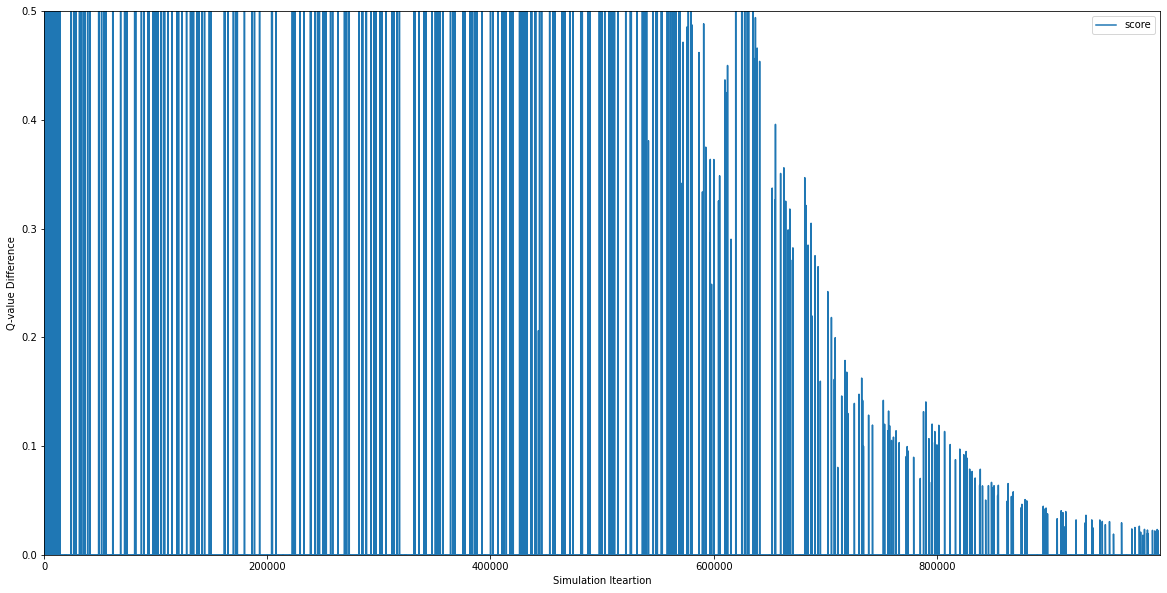

In [91]:
errors = read_stats('qlearning.txt')

ax = errors.plot.line(figsize=(20, 10), ylim=(0, 0.5))
ax.set_xlabel("Simulation Iteartion")
ax.set_ylabel("Q-value Difference")

In [131]:
class CorrolatedQ(object):
    def __init__(self, episodes_number):
        self.env = SoccerAgent()
        self.gamma = 0.9
        self.Q_A = None
        self.Q_B = None
        self.lr = 0.9
        self.lr_min = 0.001
        self.lr_decay = 0.999995
        self.epsilon = 1.0
        self.epsilon_decay = 0.9995
        self.epsilon_min = 0.001
        self.episodes_number = episodes_number
        self.scores = []
        self.conv = []
        
    def get_action(self, mapped_position_player_A, mapped_position_player_B, A_has_ball, epsilon):
        if np.random.random() < epsilon:  
            action_a =  np.random.randint(5)
            action_b =  np.random.randint(5)
            return action_a, action_b
        else:
            return np.argmax(self.Q_A[mapped_position_player_A][mapped_position_player_B][A_has_ball][np.random.randint(5)][:]), np.argmax(self.Q_B[mapped_position_player_B][mapped_position_player_A][int( not A_has_ball)][np.random.randint(5)][:])
        
    def min_max(self, mapped_position_player_A, mapped_position_player_B, A_has_ball):
        
        num_actions = 5
        x = cp.Variable(shape=(num_actions+1, 1), name="x")

        modified_R = np.array(self.Q_A[mapped_position_player_A][mapped_position_player_B][A_has_ball], dtype="float").T 
        modified_R = np.vstack([modified_R, np.eye(num_actions)])
        new_col = [1]*num_actions + [0]* num_actions
        modified_R_A = np.insert(modified_R, 0, new_col, axis=1) 
        
        modified_R = np.array(self.Q_B[mapped_position_player_B][mapped_position_player_A][int(not(A_has_ball))], dtype="float").T 
        modified_R = np.vstack([modified_R, np.eye(num_actions)])
        new_col = [1]*num_actions + [0]* num_actions
        modified_R_B = np.insert(modified_R, 0, new_col, axis=1) 
        
        modified_R = np.concatenate((modified_R_A, modified_R_B))
        A1 = [0] + [1] * num_actions 

        constraints = [cp.matmul(modified_R, x) >= 0, cp.matmul(A1, x) == 1, cp.sum( x[1:]) == 1]
        objective = cp.Minimize(cp.sum(x))
        problem = cp.Problem(objective, constraints)
        try:
            solution = problem.solve()
        except cp.SolverError:
            return 'problem', 'problen', 'problem'
        if x.value is None:
            return 'problem', 'problen', 'problem'
        prob = np.abs(np.array(x.value[1:])) / sum(np.abs(x.value[1:]))
        val_1 = np.sum(prob * self.Q_A[mapped_position_player_A][mapped_position_player_B][A_has_ball])
        val_2 = np.sum(prob * self.Q_B[mapped_position_player_B][mapped_position_player_A][int(not(A_has_ball))].T)
        
        return prob, val_1, val_2


    def train(self):
        
        self.Q_A = np.ones((8, 8, 2, 5, 5))
        self.Q_B = np.ones((8, 8, 2, 5, 5))
        
        Pi = np.ones((8, 8, 2, 5, 5)) * 1/25
        
        V_A = np.ones((8, 8, 2))
        V_B = np.ones((8, 8, 2))
        

        for episode in range(self.episodes_number):
            self.epsilon = self.epsilon * self.epsilon_decay if self.epsilon > self.epsilon_min else self.epsilon
            self.lr = self.lr * self.lr_decay if self.lr > self.lr_min else self.lr
            position_player_A, position_player_B, A_has_ball = self.env.reset()
            done = False
            mapped_position_player_A = position_player_A[1] *4 + position_player_A[0]
            mapped_position_player_B = position_player_B[1] *4 + position_player_B[0]
            action_player_A, action_player_B = self.get_action(mapped_position_player_A, mapped_position_player_B, A_has_ball, self.epsilon)
            
            j = 0
            while not done and j<= 100:
                j += 1
                current_Q = self.Q_A[6][5][0][2][4]
                
                new_position_player_A, new_position_player_B, new_A_has_ball, reward, done = self.env.step(action_player_A, action_player_B)
                new_mapped_position_player_A = position_player_A[1] *4 + position_player_A[0]
                new_mapped_position_player_B = position_player_B[1] *4 + position_player_B[0]
                
                new_action_player_A, new_action_player_B = self.get_action(new_mapped_position_player_A, new_mapped_position_player_B, A_has_ball, self.epsilon)
                
                self.Q_A[mapped_position_player_A][mapped_position_player_B][A_has_ball][action_player_B][action_player_A] = self.lr * (reward + (self.gamma* V_A[new_mapped_position_player_A][new_mapped_position_player_B][new_A_has_ball]) - (1-self.lr) * self.Q_A[mapped_position_player_A][mapped_position_player_B][A_has_ball][action_player_B][action_player_A])    
                self.Q_B[mapped_position_player_B][mapped_position_player_A][int(not A_has_ball)][action_player_A][action_player_B] = self.lr * (-reward + (self.gamma* V_B[new_mapped_position_player_B][new_mapped_position_player_A][int(not A_has_ball)]) - self.Q_B[mapped_position_player_B][mapped_position_player_A][int(not A_has_ball)][action_player_A][action_player_B])
                
                prob, val_1, val_2 = self.min_max(mapped_position_player_A, mapped_position_player_B, A_has_ball)
                
                if not prob == 'problem':

                    Pi[mapped_position_player_A][mapped_position_player_B][A_has_ball] = prob
                    V_A[mapped_position_player_A][mapped_position_player_B][A_has_ball] = val_1
                    V_B[mapped_position_player_B][mapped_position_player_A][int(not(A_has_ball))] = val_2
            
                action_player_A = new_action_player_A
                action_player_B = new_action_player_B
                
                position_player_A = new_position_player_A
                action_player_B = new_action_player_B
                
                mapped_position_player_A = new_mapped_position_player_A
                mapped_position_player_B = new_mapped_position_player_B
                
                A_has_ball = new_A_has_ball
                
                new_Q = self.Q_A[6][5][0][2][4]
                
                self.conv.append(new_Q-current_Q)
        return self.conv
        
        

In [132]:
solvers.options['show_progress'] = False

corrolated_q_errors = CorrolatedQ(1000000).train()
save_stats(corrolated_q_errors, 'corrolatedq.txt')

/home/gomni/.local/lib/python3.6/site-packages/ipykernel_launcher.py:135: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


!!!
!!!
!!!
!!!
!!!
!!!
!!!
!!!
!!!
!!!
!!!
!!!
!!!
!!!
!!!
!!!
!!!
!!!
!!!
!!!
!!!
!!!
!!!
!!!
!!!
!!!
!!!
!!!
!!!
!!!
!!!
!!!
!!!
None!
!!!
None!
!!!
!!!
!!!
!!!
!!!
!!!
!!!
!!!
!!!
!!!
!!!
!!!
!!!
!!!
!!!
!!!
!!!
!!!
!!!
!!!
!!!
!!!
!!!
!!!
!!!
!!!
!!!
!!!
!!!
!!!
!!!
!!!
!!!
!!!
!!!
!!!
!!!
!!!
!!!
!!!
!!!
!!!
!!!
!!!
!!!
!!!
!!!
!!!
!!!
!!!
!!!
!!!
!!!
!!!
!!!
!!!
!!!
!!!
!!!
!!!
!!!
!!!
!!!
!!!
!!!
!!!
!!!
!!!
!!!
!!!
!!!
!!!
!!!
!!!
!!!
!!!
!!!
!!!
!!!
!!!
!!!
!!!
!!!
!!!
None!
!!!
!!!
!!!
!!!
!!!
!!!
!!!
!!!
!!!
!!!
!!!
!!!
!!!
!!!
!!!
!!!
!!!
!!!
!!!
!!!
!!!
!!!
!!!
!!!
!!!
!!!
!!!
!!!
!!!
!!!
!!!
!!!
!!!
!!!
!!!
!!!
!!!
!!!
!!!
!!!
!!!
!!!
!!!
!!!
!!!
!!!
!!!
!!!
!!!
!!!
None!
None!
!!!
!!!
!!!
!!!
!!!
!!!
!!!
!!!
!!!
!!!
!!!
!!!
!!!
!!!
!!!
!!!
!!!
!!!
!!!
!!!
!!!
!!!
None!
!!!
!!!
!!!
!!!
!!!
!!!
!!!
!!!
!!!
!!!
!!!
!!!
!!!
!!!
!!!
!!!
!!!
!!!
!!!
!!!
None!
!!!
!!!
!!!
!!!
!!!
!!!
!!!
!!!
!!!
!!!
!!!
!!!
None!
!!!
!!!
!!!
!!!
None!
!!!
!!!
!!!
!!!
!!!
!!!
None!
!!!
None!
No

!!!
!!!
!!!
None!
!!!
!!!
!!!
!!!
!!!
!!!
!!!
!!!
!!!
None!
!!!
None!
!!!
!!!
None!
None!
None!
None!
!!!
!!!
!!!
!!!
!!!
!!!
!!!
!!!
!!!
None!
!!!
!!!
!!!
!!!
!!!
!!!
!!!
!!!
!!!
!!!
!!!
!!!
!!!
!!!
!!!
!!!
!!!
None!
!!!
!!!
!!!
!!!
!!!
None!
None!
!!!
!!!
!!!
!!!
!!!
!!!
None!
!!!
!!!
!!!
!!!
!!!
!!!
None!
None!
!!!
!!!
!!!
!!!
!!!
!!!
!!!
!!!
!!!
!!!
!!!
None!
None!
!!!
!!!
!!!
None!
!!!
!!!
!!!
!!!
None!
None!
None!
!!!
!!!
!!!
!!!
!!!
!!!
None!
!!!
!!!
!!!
!!!
!!!
None!
!!!
!!!
!!!
None!
!!!
!!!
!!!
!!!
!!!
!!!
!!!
!!!
!!!
!!!
!!!
None!
None!
!!!
None!
!!!
!!!
!!!
!!!
None!
None!
None!
!!!
None!
None!
!!!
!!!
!!!
!!!
!!!
!!!
!!!
!!!
None!
!!!
!!!
None!
None!
None!
!!!
!!!
!!!
!!!
!!!
!!!
!!!
None!
!!!
!!!
None!
None!
None!
!!!
!!!
!!!
None!
!!!
None!
!!!
None!
None!
!!!
!!!
None!


KeyboardInterrupt: 

Text(0, 0.5, 'Q-value Difference')

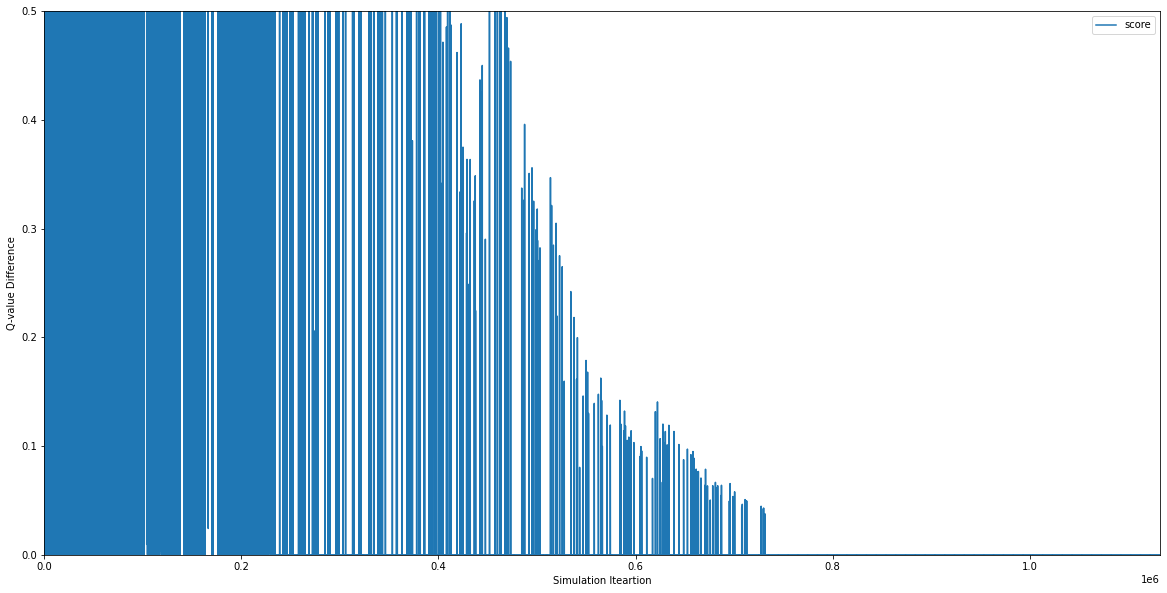

In [92]:
import matplotlib as mpl

mpl.rcParams['agg.path.chunksize'] = 10000

corrolated_q_errors = read_stats('corrolatedq.txt')
ax = corrolated_q_errors.plot.line(figsize=(20, 10), ylim=(0, 0.5))
ax.set_xlabel("Simulation Iteartion")
ax.set_ylabel("Q-value Difference")

In [7]:
class FriendQ(object):
    def __init__(self, episodes_number):
        self.env = SoccerAgent()
        self.gamma = 0.9
        self.Q_A = None
        self.Q_B = None
        self.lr = 0.9
        self.lr_min = 0.001
        self.lr_decay = 0.999995
        self.epsilon = 1.0
        self.epsilon_decay = 0.9995
        self.epsilon_min = 0.001
        self.episodes_number = episodes_number
        self.scores = []
        self.conv = []
        
    def get_action(self, mapped_position_player_A, mapped_position_player_B, A_has_ball, epsilon):
        if np.random.random() < epsilon:  
            action_a =  np.random.randint(5)
            action_b =  np.random.randint(5)
            return action_a, action_b
        else:
            return np.argmax(self.Q_A[mapped_position_player_A][mapped_position_player_B][A_has_ball][np.random.randint(5)][:]), np.argmax(self.Q_B[mapped_position_player_B][mapped_position_player_A][int( not A_has_ball)][np.random.randint(5)][:])
        
        
    def train(self):
        self.Q_A = np.zeros((8, 8, 2, 5, 5))
        self.Q_B = np.zeros((8, 8, 2, 5, 5))
        

        for episode in range(self.episodes_number):
            self.epsilon = self.epsilon * self.epsilon_decay if self.epsilon > self.epsilon_min else self.epsilon
            self.lr =  1 / (episode / self.lr_min / self.episodes_number + 1)
            position_player_A, position_player_B, A_has_ball = self.env.reset()
            done = False
            mapped_position_player_A = position_player_A[1] *4 + position_player_A[0]
            mapped_position_player_B = position_player_B[1] *4 + position_player_B[0]
            action_player_A, action_player_B = self.get_action(mapped_position_player_A, mapped_position_player_B, A_has_ball, self.epsilon)
            
            current_Q = self.Q_A[6][5][0][2][4]

            while not done:
                new_position_player_A, new_position_player_B, new_A_has_ball, reward, done = self.env.step(action_player_A, action_player_B)
                new_mapped_position_player_A = position_player_A[1] *4 + position_player_A[0]
                new_mapped_position_player_B = position_player_B[1] *4 + position_player_B[0]
                
                new_action_player_A, new_action_player_B = self.get_action(new_mapped_position_player_A, new_mapped_position_player_B, A_has_ball, self.epsilon)
                next_Q_A = max(self.Q_A[mapped_position_player_A][mapped_position_player_B][A_has_ball][action_player_A][:])
                next_Q_B = max(self.Q_B[mapped_position_player_B][mapped_position_player_A][int(not A_has_ball)][action_player_B][:])
                
                self.Q_A[mapped_position_player_A][mapped_position_player_B][A_has_ball][action_player_B][action_player_A] += self.lr * (reward + (self.gamma* next_Q_A) - self.Q_A[mapped_position_player_A][mapped_position_player_B][A_has_ball][action_player_B][action_player_A])
                self.Q_B[mapped_position_player_B][mapped_position_player_A][int(not A_has_ball)][action_player_A][action_player_B] += self.lr * (-reward + (self.gamma* next_Q_B) - self.Q_B[mapped_position_player_B][mapped_position_player_A][int(not A_has_ball)][action_player_A][action_player_B])
                
                action_player_A = new_action_player_A
                action_player_B = new_action_player_B
                
                position_player_A = new_position_player_A
                action_player_B = new_action_player_B
                mapped_position_player_A = new_mapped_position_player_A
                mapped_position_player_B = new_mapped_position_player_B
                
                A_has_ball = new_A_has_ball
                
            new_Q = self.Q_A[6][5][0][2][4]
            self.conv.append(new_Q-current_Q)
        return self.conv

In [8]:
friend_q_errors = FriendQ(1000000).train()
save_stats(friend_q_errors, 'friendq.txt')

Text(0, 0.5, 'Q-value Difference')

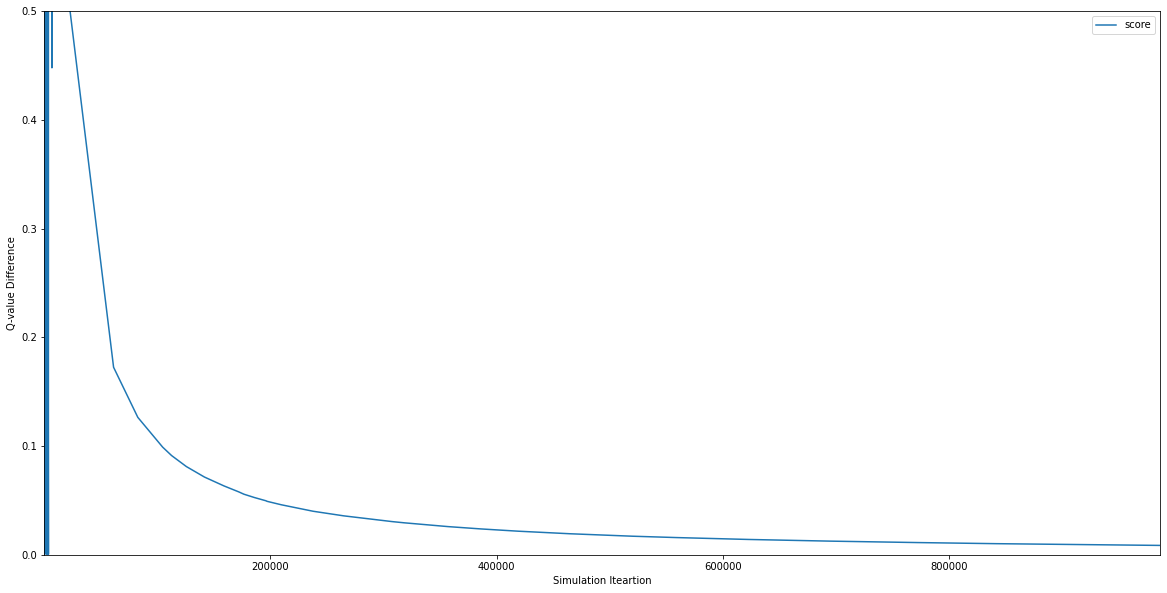

In [93]:
friend_q_errors = read_stats('friendq.txt')
friend_q_errors = friend_q_errors[friend_q_errors['score'] > 0]
ax = friend_q_errors.plot.line(figsize=(20,10), ylim=(0, 0.5))
ax.set_xlabel("Simulation Iteartion")
ax.set_ylabel("Q-value Difference")

In [37]:
class FoeQ(object):
    def __init__(self, episodes_number):
        self.env = SoccerAgent()
        self.gamma = 0.9
        self.Q_A = None
        self.Q_B = None
        self.lr = 0.9
        self.lr_min = 0.001
        self.lr_decay = 0.999995
        self.epsilon = 1.0
        self.epsilon_decay = 0.9995
        self.epsilon_min = 0.001
        self.episodes_number = episodes_number
        self.scores = []
        self.conv = []
        
    def max_min(self, Q, mapped_position_player, mapped_position_opponent, has_ball):
        num_actions = 5
        x = cp.Variable(shape=(num_actions+1, 1), name="x")

        modified_R = np.array(Q[mapped_position_player][mapped_position_opponent][has_ball], dtype="float").T 
        
        modified_R = np.vstack([modified_R, np.eye(num_actions)])
        new_col = [1]*num_actions + [0]* num_actions
        modified_R = np.insert(modified_R, 0, new_col, axis=1) 
    
        A1 = [0] + [1] * num_actions 

        constraints = [cp.matmul(modified_R, x) >= 0, cp.matmul(A1, x) == 1, cp.sum( x[1:]) == 1]
        objective = cp.Minimize(cp.sum(x))
        problem = cp.Problem(objective, constraints)
        solution = problem.solve()
        #print(np.abs(x.value[1:]).reshape((5,) / sum(np.abs(x.value[1:]))[0]))
        return np.abs(x.value[1:]).reshape((5,)) / int(sum(np.abs(x.value[1:]))[0]), np.array(x.value[0])
        
        
        
    def get_action(self, mapped_position_player_A, mapped_position_player_B, A_has_ball, epsilon):
        if np.random.random() < epsilon:  
            action_a =  np.random.randint(5)
            action_b =  np.random.randint(5)
            return action_a, action_b
        else:
            return np.argmax(self.Q_A[mapped_position_player_A][mapped_position_player_B][A_has_ball][np.random.randint(5)][:]), np.argmax(self.Q_B[mapped_position_player_B][mapped_position_player_A][int( not A_has_ball)][np.random.randint(5)][:])
        
        
    def train(self):
        self.Q_A = np.ones((8, 8, 2, 5, 5))
        self.Q_B = np.ones((8, 8, 2, 5, 5))
        
        Pi_A = np.ones((8, 8, 2, 5)) * 1/5
        Pi_B = np.ones((8, 8, 2, 5)) * 1/5
        
        V_A = np.ones((8, 8, 2))
        V_B = np.ones((8, 8, 2))
        

        for episode in range(self.episodes_number):
            self.epsilon = self.epsilon * self.epsilon_decay if self.epsilon > self.epsilon_min else self.epsilon
            self.lr = self.lr * self.lr_decay if self.lr > self.lr_min else self.lr
            position_player_A, position_player_B, A_has_ball = self.env.reset()
            done = False
            mapped_position_player_A = position_player_A[1] *4 + position_player_A[0]
            mapped_position_player_B = position_player_B[1] *4 + position_player_B[0]
            action_player_A, action_player_B = self.get_action(mapped_position_player_A, mapped_position_player_B, A_has_ball, self.epsilon)
            
            current_Q = self.Q_A[6][5][0][2][4]

            while not done:
                new_position_player_A, new_position_player_B, new_A_has_ball, reward, done = self.env.step(action_player_A, action_player_B)
                new_mapped_position_player_A = position_player_A[1] *4 + position_player_A[0]
                new_mapped_position_player_B = position_player_B[1] *4 + position_player_B[0]
                
                new_action_player_A, new_action_player_B = self.get_action(new_mapped_position_player_A, new_mapped_position_player_B, A_has_ball, self.epsilon)
                
                self.Q_A[mapped_position_player_A][mapped_position_player_B][A_has_ball][action_player_B][action_player_A] = self.lr * (reward + (self.gamma* V_A[new_mapped_position_player_A][new_mapped_position_player_B][new_A_has_ball]) - (1-self.lr) * self.Q_A[mapped_position_player_A][mapped_position_player_B][A_has_ball][action_player_B][action_player_A])    
                self.Q_B[mapped_position_player_B][mapped_position_player_A][int(not A_has_ball)][action_player_A][action_player_B] = self.lr * (-reward + (self.gamma* V_B[new_mapped_position_player_B][new_mapped_position_player_A][int(not A_has_ball)]) - self.Q_B[mapped_position_player_B][mapped_position_player_A][int(not A_has_ball)][action_player_A][action_player_B])

                Pi_A[mapped_position_player_A][mapped_position_player_B][A_has_ball], V_A[mapped_position_player_A][mapped_position_player_B][A_has_ball] = self.max_min(self.Q_A, mapped_position_player_A, mapped_position_player_B, A_has_ball)
                Pi_B[mapped_position_player_B][mapped_position_player_A][int(not A_has_ball)], V_B[mapped_position_player_B][mapped_position_player_A][int(not A_has_ball)] =self.max_min(self.Q_B, mapped_position_player_B, mapped_position_player_A, int(not A_has_ball))

    
                action_player_A = new_action_player_A
                action_player_B = new_action_player_B
                
                position_player_A = new_position_player_A
                action_player_B = new_action_player_B
                mapped_position_player_A = new_mapped_position_player_A
                mapped_position_player_B = new_mapped_position_player_B
                
                A_has_ball = new_A_has_ball
                
            new_Q = self.Q_A[6][5][0][2][4]
            self.conv.append(new_Q-current_Q)
        return self.conv

In [41]:
foe_q = FoeQ(1000000).train()
save_stats(foe_q, 'foeq.txt')

/home/gomni/.local/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in true_divide


Text(0, 0.5, 'Q-value Difference')

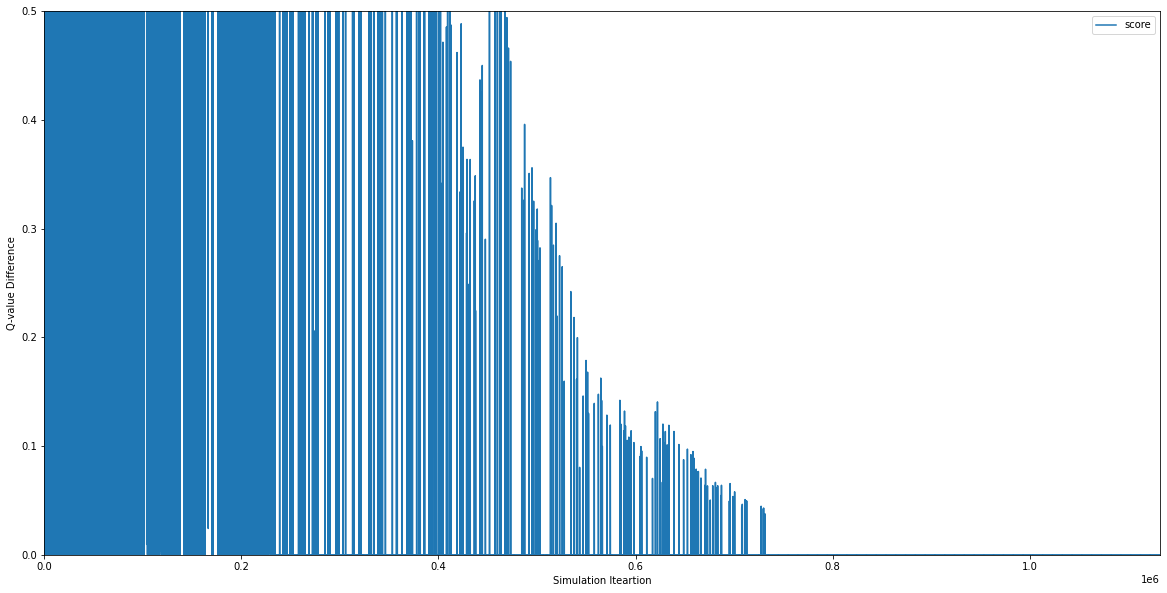

In [94]:
foe_q = read_stats('foeq.txt')
ax = foe_q.plot.line(figsize=(20, 10), ylim=(0, 0.5))
ax.set_xlabel("Simulation Iteartion")
ax.set_ylabel("Q-value Difference")